In [24]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam

import numpy as np
import random
from collections import deque

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=''):
        self.state_size = state_size # normalized previous days
        self.action_size = 5 #  buy_1, sell_1,DO Nothing, buy2, sell2
        self.memory = deque(maxlen=2000)
        self.inventory1 = []
        self.inventory2 = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95 #gamma is the discount factor. It quantifies how much importance we give for future rewards.
        self.epsilon = 1.0 #Exploration and Exploitation — Epsilon (ε)
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        # self.model = load_model("models/" + model_name) if is_eval else self._model()
        self.model = self._model()

#     def _model(self):
#         model = Sequential()
#         model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
#         model.add(Dense(units=32, activation="relu"))
#         model.add(Dense(units=8, activation="relu"))
#         model.add(Dense(self.action_size, activation="linear"))
#         model.compile(loss="mse", optimizer=Adam(lr=0.0001))
#         return model
    def _model(self):
        model = Sequential()
        model.add(Dense(units=128, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=64, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.0001))
        return model

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
#             print("random action")
            return random.randrange(self.action_size)
#         print("Calculating using model")
        options = self.model.predict(state)
        #print(str(options))
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
              
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 


In [25]:
import numpy as np
import random
import math, random 
import gym 
import numpy as np 


class State:
    def __init__(self, data1, data2, Bal_stock1, Bal_stock2, open_cash, timestep):
        self.Stock1Price=data1[timestep] #stock 1 open price
        self.Stock2Price=data2[timestep] #stock 2 open price
        self.Stock1Blnc=Bal_stock1 #stock 1 balance
        self.Stock2Blnc=Bal_stock2 #stock 2 balance
        self.open_cash=open_cash #cash balance
        self.fiveday_stock1=self.five_day_window(data1, timestep)
        self.fiveday_stock2=self.five_day_window(data2, timestep)
        #self.volume1=volume1[timestep]
        #self.volume2=volume2[timestep]
        self.portfolio_value=self.portfolio_value()

    def portfolio_value(self):
        pvalue=0
        #print("In portfolio func")
        #print("self.Stock1Price",self.Stock1Price, type(self.Stock1Price))
        #print("self.Stock1Blnc",self.Stock1Blnc[0], type(self.Stock1Blnc))

        v1=self.Stock1Price * float(self.Stock1Blnc)
        v2=self.Stock2Price * float(self.Stock2Blnc)
        v3=float(self.open_cash)
        return (v1+v2+v3)
    
    def next_opening_price(self):
        return [data1[timestep+1], data2[timestep+1]]
    
    def five_day_window(self,data, timestep):
        step = timestep
        if step < 5:
            return data[0]
        
        stock_5days = np.mean(data[step-5:step])
        #print("stock_5days=" + str(stock_5days))
        #print(stock_5days)

        #print(type(stock_5days))

        return stock_5days
    
    def reset(self):
        #self.state = torch.FloatTensor(torch.zeros(8)).cuda()
#         self.Stock1Price=151.25 #stock 1 open price Google
#         self.Stock2Price=21.845 #stock 2 open price Walmart
#         self.Stock1Blnc=34 #stock 1 balance Google
#         self.Stock2Blnc=221 #stock 2 balance Walmart
        self.Stock1Price=151.25 #stock 1 open price Google
        self.Stock2Price=21.845 #stock 2 open price Walmart
        self.Stock1Blnc=50 #stock 1 balance Google
        self.Stock2Blnc=50 #stock 2 balance Walmart
        self.open_cash=100000 #cash balance
        self.fiveday_stock1=151.25
        self.fiveday_stock2=21.845
        self.portfolio_value=100000
        
    def getState(self):
        #print("In get state")
        res=[]
        res.append(self.Stock1Price) #stock 1 open price
        res.append(self.Stock2Price) #stock 2 open price
        res.append(self.Stock1Blnc) #stock 1 balance
        res.append(self.Stock2Blnc) #stock 2 balance
        res.append(self.open_cash) #cash balance
        res.append(self.fiveday_stock1)
        res.append(self.fiveday_stock2)        
        res.append(self.portfolio_value)
        #res.append(self.volume1)
        #res.append(self.volume2)


        
        #print(res)
        res1=np.array([res])
        #print("res array"+np.array([res]))
        return res1

In [26]:
import numpy as np
import math

# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the vector containing stock data from a fixed file
def getStockDataVec(key):
    vec = []
    lines = open("data/" + key + ".txt", "r").read().splitlines()

    for line in lines[1:]:
        vec.append(float(line.split(",")[4]))

    return vec


# returns the vector containing stock data from a fixed file
def getStockVolVec(key):
    vol = []
    # lines = open("key + ".txt", "r").read().splitlines()
    data = key['Volume']
    for i in range(len(data)):
        vol.append(float(i))

    return vol

# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))



In [27]:
import pandas as pd
import sys

import pandas as pd

import math, random 
import numpy as np 
from datetime import datetime, timedelta
# from google.colab import files
# import io

#stock_name, window_size, episode_count = sys.argv[1], int(sys.argv[2]), int(sys.argv[3])

stock_name1,stock_name2, episode_count, start_balance, training, test = 'aapl.us','amzn.us', 51,10000,1500,500


# pd_data1=pd.read_csv('data/aapl.us.txt', sep=",", header=0)
# pd_data2=pd.read_csv('data/amzn.us.txt', sep=",", header=0)
# uploaded = files.upload()
# pd_data1 = pd.read_csv(io.BytesIO(uploaded['ACN.csv'])) 
# uploaded = files.upload()
# pd_data2 = pd.read_csv(io.BytesIO(uploaded['AMZN.csv'])) 

pd_data1 = pd.read_csv('/Users/pranavsaxena/Desktop/Python/Dissertation-Datasets/ACN.csv')  
pd_data2 = pd.read_csv('/Users/pranavsaxena/Desktop/Python/Dissertation-Datasets/AMZN.csv')  
training = int(0.8*len(pd_data1))
test = int(0.2*len(pd_data1))
# print(training)
# print(test)


### Data Pre-processing

In this section we will do the following:
1. Look at the data of Apple and Amazon stock for checking anamolies (missing data etc.). Also convert date into right format
2. Make sure that both the stock data is for the same time period and same days in this time period. Remove data if necessary
3. Look at descriptive statistics of data- mean, median, number of records
4. Visualize the data to see how stock price changes with time
    

#### View Apple Stock data

In [28]:

pd_data1.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-07-19,15.10,15.29,15.00,15.17,11.311725,34994300
1,2001-07-20,15.05,15.05,14.80,15.01,11.192417,9238500
2,2001-07-23,15.00,15.01,14.55,15.00,11.184960,7501000
3,2001-07-24,14.95,14.97,14.70,14.86,11.080566,3537300
4,2001-07-25,14.70,14.95,14.65,14.95,11.147676,4208100


#### View Amazon Stock data


In [29]:

pd_data2.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


#### Date in Above data is not in Dateformat, so converting date to date format 

In [30]:
#Convert  Date to Date format
pd_data1['Date']=pd.to_datetime(pd_data1['Date'], format='%Y/%m/%d')
pd_data2['Date']=pd.to_datetime(pd_data2['Date'], format='%Y/%m/%d')

#### Desciptive statistics of Apple and Amazon data

Apple Stock- descriptive statistics

In [31]:
pd_data1.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4779.000000,4779.000000,4779.000000,4779.000000,4779.000000,4.779000e+03
mean,70.416303,71.089454,69.786865,70.489753,63.236394,3.020266e+06
std,52.447950,52.830035,52.079890,52.472566,53.269560,2.669813e+06
min,11.400000,12.260000,11.300000,11.850000,8.836119,1.811000e+05
25%,28.459999,28.894999,28.080000,28.580000,21.723793,1.869500e+06
50%,49.509998,50.020000,48.720001,49.820000,40.573673,2.496500e+06
75%,101.529999,102.574997,100.585003,101.790001,93.329174,3.527100e+06
max,221.330002,222.750000,218.600006,221.940002,221.940002,8.965590e+07


Amazon Stock- descriptve statistics

In [32]:
pd_data2.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5.832000e+03
mean,368.066545,372.205061,363.569618,368.115545,368.115545,7.522746e+06
std,575.225127,581.189758,568.633887,575.312625,575.312625,7.288057e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,37.912498,38.520000,37.169998,37.878751,37.878751,3.684175e+06
50%,83.137501,84.844997,81.385002,83.122501,83.122501,5.658650e+06
75%,358.435005,361.184990,354.419998,358.667504,358.667504,8.539575e+06
max,3251.060059,3344.290039,3135.699951,3200.000000,3200.000000,1.043292e+08


#### Drop Data that is not in both stock data- some days data is missing in Apple and some in Amazon

I have made another program to look at data that is common in both stocks and to find out if there are any anamolies. Using this program I found out some data that is missing in either Apple or Amazon stock data


In [33]:
pd_data2['Date'][0]

Timestamp('1997-05-15 00:00:00')

In [34]:
pd_data1['Date'][0]

Timestamp('2001-07-19 00:00:00')

In [35]:
if (pd_data1['Date'][0]>pd_data2['Date'][0]): 
    #print("Date1 is older than Date2")
    pd_data1=pd_data1[pd_data1.Date>=pd_data2['Date'][0]]
    pd_data1=pd_data1.reset_index(drop=True)
else:
    #print("Date2>Date1")
    pd_data2=pd_data2[pd_data2.Date>=pd_data1['Date'][0]]
    pd_data2=pd_data2.reset_index(drop=True)
    #print("Date2>Date1  and date2 is" + str(pd_data2['Date'][0]) +" Date 1 is : "+ str(pd_data1['Date'][0]))

In [36]:
pd_data2.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5.832000e+03
mean,368.066545,372.205061,363.569618,368.115545,368.115545,7.522746e+06
std,575.225127,581.189758,568.633887,575.312625,575.312625,7.288057e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,37.912498,38.520000,37.169998,37.878751,37.878751,3.684175e+06
50%,83.137501,84.844997,81.385002,83.122501,83.122501,5.658650e+06
75%,358.435005,361.184990,354.419998,358.667504,358.667504,8.539575e+06
max,3251.060059,3344.290039,3135.699951,3200.000000,3200.000000,1.043292e+08


In [37]:
# Pre -Processing the Datasheet ...Drop Data that is not in both stock data- some days data is missing in Apple and some in Amazon
import datetime
#timestamp = data1_date[10]
#print(timestamp.strftime('%Y-%m-%d'))
list1= pd_data1['Date']
list2= pd_data2['Date']
diff_pd1_data = list(set(list1) - set(list2))
diff_pd2_data = list(set(list2) - set(list1))
#x11=x[0].strftime('%Y-%m-%d 00:00:00')
#p=datetime.datetime.strptime(x11, "%Y-%m-%d 00:00:00")
#print(p)
for k in range(len(diff_pd1_data)):
    pd1_dat_format=diff_pd1_data[k].strftime('%Y-%m-%d 00:00:00')
    date_format_pd1=datetime.datetime.strptime(pd1_dat_format, "%Y-%m-%d 00:00:00")
    for i, j in enumerate(list1):
        if j == date_format_pd1:
            #print(i)
            pd_data1=pd_data1.drop([i])            
pd_data1=pd_data1.reset_index(drop=True)

for k in range(len(diff_pd2_data)):
    pd2_dat_format=diff_pd2_data[k].strftime('%Y-%m-%d 00:00:00')
    date_format_pd2=datetime.datetime.strptime(pd2_dat_format, "%Y-%m-%d 00:00:00")
    for M, N in enumerate(list2):
        if N == date_format_pd2:
            #print(M)
            pd_data2=pd_data2.drop([M])
            
pd_data2=pd_data2.reset_index(drop=True) 


Now the data is clean, both Apple and Amazon have 5151 records

In [38]:
pd_data1.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4779.000000,4779.000000,4779.000000,4779.000000,4779.000000,4.779000e+03
mean,70.416303,71.089454,69.786865,70.489753,63.236394,3.020266e+06
std,52.447950,52.830035,52.079890,52.472566,53.269560,2.669813e+06
min,11.400000,12.260000,11.300000,11.850000,8.836119,1.811000e+05
25%,28.459999,28.894999,28.080000,28.580000,21.723793,1.869500e+06
50%,49.509998,50.020000,48.720001,49.820000,40.573673,2.496500e+06
75%,101.529999,102.574997,100.585003,101.790001,93.329174,3.527100e+06
max,221.330002,222.750000,218.600006,221.940002,221.940002,8.965590e+07


In [39]:
pd_data2.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4779.000000,4779.000000,4779.000000,4779.000000,4779.000000,4.779000e+03
mean,441.710927,446.464101,436.539780,441.787602,441.787602,6.352886e+06
std,611.222884,617.653114,604.114432,611.306544,611.306544,5.095169e+06
min,5.910000,6.100000,5.510000,5.970000,5.970000,8.813000e+05
25%,44.185000,45.034999,43.600001,44.470002,44.470002,3.515850e+06
50%,175.500000,177.699997,173.589996,175.619995,175.619995,5.273100e+06
75%,539.835022,545.429993,532.829987,537.940002,537.940002,7.590700e+06
max,3251.060059,3344.290039,3135.699951,3200.000000,3200.000000,1.043292e+08


### Data Visualization

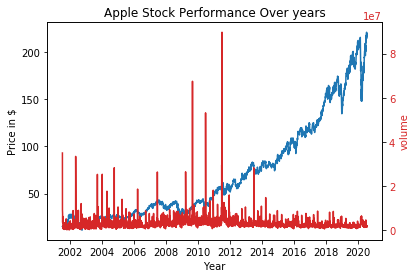

In [40]:
# Apple Stock Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

x1 = np.array(pd_data1['Date'])
y1 = pd_data1['Open']
y12= pd_data1['Volume']

plt.title("Apple Stock Performance Over years")
plt.xlabel("Year")
plt.ylabel("Price in $")



plt.plot(x1,y1)


ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
ax2.plot(x1, y12, color=color)
ax2.tick_params(axis='y', labelcolor=color)



plt.show()

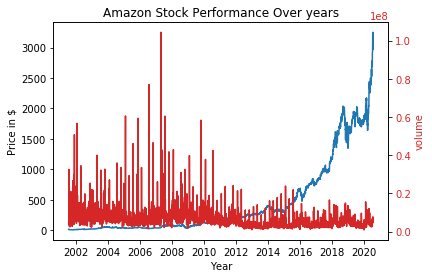

In [41]:
# Amazon Stock Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

x2 = np.array(pd_data2['Date'])
y2 = pd_data2['Open']
y22= pd_data2['Volume']


plt.title("Amazon Stock Performance Over years")
plt.xlabel("Year")
plt.ylabel("Price in $")

plt.plot(x2,y2)


ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
ax2.plot(x2, y22, color=color)
ax2.tick_params(axis='y', labelcolor=color)




plt.show()

### Divide Training and test data

Next step is to divide data into training and test set. This has to be done in a chronological order. So, data is divided into:
- training set from days 0 to days 'training'
- test set: from days 'training' to day 'training+ test'

In [42]:
#Training Data
pd_data1_train=pd_data1[0:training]
pd_data2_train=pd_data2[0:training]

In [43]:
#Test Data
pd_data1_test=pd_data1[training:training+test]
pd_data2_test=pd_data2[training:training+test]

In [44]:
vol1_train=getStockVolVec(pd_data1)
vol2_train=getStockVolVec(pd_data2)

In [45]:
#Initialize state and set benchmarking model

total_Prof=[]
done=False


batch_size = 64

#Benchmark Model
#In this model, we would divide 


#Initialize state and set benchmarking model


#print(df_data1)
total_Prof=[]
done=False

Act_datasize = training
batch_size = 64

#Benchmark Model

data1_train=pd_data1_train['Close']
data2_train=pd_data2_train['Close']

data1_date=pd_data1_train['Date']

Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_train[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_train[0]))
Act_Bench_Open_cash=start_balance/2




### Program to calculate benchmark profit


#sell 10% of stock in 10 intervals

interval=int(Act_datasize/10)
Total_Stock1_Amount= 0
Total_Stock2_Amount= 0
stocks2Value = 0
stocks1Value = 0

Act_stocks1=np.floor(Act_Bench_Stock1_Bal /10)
Act_stocks2=np.floor(Act_Bench_Stock2_Bal /10)
#print(str(Act_stocks1))
#print(str(Act_stocks2))

remaining_stock1=Act_Bench_Stock1_Bal
remaining_stock2=Act_Bench_Stock2_Bal
ttl=0

Benchmark_Port_Value=[]


for j in range (interval,Act_datasize+1,interval):
        #print("closing prices : " + str(data1_train[j-1]) )
        Price_closing_Stock1=data1_train[j-1]
        Price_closing_Stock2=data2_train[j-1]
        
        date_stock1=data1_date[j-1].strftime('%Y-%m-%d')
        #print(date_stock1)
                
        stocks1Value= Act_stocks1 * Price_closing_Stock1
        stocks2Value= Act_stocks2 * Price_closing_Stock2
        remaining_stock1=remaining_stock1-Act_stocks1
        remaining_stock2=remaining_stock2-Act_stocks2
        #print("J is:"+ str(j))
        
        
        
        Stock1_Port_value=remaining_stock1*Price_closing_Stock1
        Stock2_Port_value=remaining_stock2*Price_closing_Stock2
        Act_Bench_Open_cash=Act_Bench_Open_cash+stocks1Value+stocks2Value #Adding 10% sold value into open cash
        
        Total_Portfolio_value=Act_Bench_Open_cash+Stock1_Port_value+Stock2_Port_value
        Benchmark_Port_Value.append([date_stock1,Total_Portfolio_value])
        



#print ("total_Test_Benchmark_amount : " +  str(Total_Portfolio_value))

Training_Benchmark_Portfolio_Value= Total_Portfolio_value




print("Benchmark_Profit is  " + str(Training_Benchmark_Portfolio_Value) +" with Apple Stocks:  " + str(remaining_stock1) + 
      " and Amazon stocks:  "+ str(remaining_stock2) )


#Define arrays to store per episode values 
total_Prof=[]
total_stock1bal=[]
total_stock2bal=[]
total_open_cash=[]
total_port_value=[]
total_days_played=[]





Benchmark_Profit is  44879.269614 with Apple Stocks:  4.0 and Amazon stocks:  1.0


# Training Run

In [46]:
#Training run

import csv

for e in range(episode_count + 1):
    print("..........")
    print("Episode " + str(e) + "/" + str(episode_count))
    
#     Bal_stock1=int(np.floor((start_balance/4)/data1_train[0]))
#     Bal_stock2=int(np.floor((start_balance/4)/data2_train[0]))
#     open_cash=start_balance/2
    Bal_stock1=50
    Bal_stock2=50
    open_cash=100000
    
    datasize=training
    done=False
    total_profit = 0
    reward = 0
    
    #Initialize Agent
    agent = Agent(8)
    agent.inventory1 =[]
    agent.inventory2 =[]
    for i in range(Bal_stock1):
        agent.inventory1.append(data1_train[0])
    for i in range(Bal_stock2):
        agent.inventory2.append(data2_train[0]) 
    
    
    #Timestep delta to make sure that with time reward increases for taking action
    #timestep_delta=0
    act_arr = []
    #Running episode over all days in the datasize
    for t in range(datasize):
        #print("..........")
        #print(pd_data1_train.iloc[t,0])
        state_class_obj= State(data1_train, data2_train, Bal_stock1, Bal_stock2, open_cash,t)
        state_array_obj=state_class_obj.getState()
        action = agent.act(state_array_obj)
         
                   
        change_percent_stock1=(state_class_obj.Stock1Price-state_class_obj.fiveday_stock1)/state_class_obj.fiveday_stock1*100
        change_percent_stock2=(state_class_obj.Stock2Price-state_class_obj.fiveday_stock2)/state_class_obj.fiveday_stock2*100
        
        #print("change_percent_stock1:  "+str(change_percent_stock1))
        #print("change_percent_stock2:  "+str(change_percent_stock2))
        
#         act_arr.append(action)
        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:
                '''
                print("Buy stock 1 when it did not have cash, so bankrupt, end of episode")
                reward=-reward_timedelta*10
                done = True
                '''
                #If agent is trying to buy when it has no cash but has stock1 and stock2 balance then, 
                #it should pick from other actions
                #if (state_class_obj.Stock1Blnc>1) and  (state_class_obj.Stock2Blnc>1):
                 #   action=random.sample([1, 2, 4, 5, 6],  1)  # Choose 1 elements from sell actions
                #else:    
                #print("Bankrupt")
                reward=-200000
                done = True
                #end episode
                     
            else:
                #print("In Buy stock 1")
                act_arr.append(action)
                agent.inventory1.append(data1_train[t])
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash-state_class_obj.Stock1Price #Here we are buying 1 stock
                
                #needs to be reviewed
                
                if(state_class_obj.open_cash<500):
                    reward=-100000
                elif (abs(change_percent_stock1)<=2):
                    reward=-10000
                else:  
                    reward=-change_percent_stock1*100
                

               
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <5 :
               # print("sold stock 2 when it did not have stock 2, so bankrupt, end of episode")
                reward=-200000
                done = True
                #end episode
            else:
                act_arr.append(action)
                #print("In sell stock 1")
                bought_price1=agent.inventory1.pop(0)
#                 bought_price1=agent.inventory1.pop(0)
#                 bought_price1=agent.inventory1.pop(0)
#                 bought_price1=agent.inventory1.pop(0)
#                 bought_price1=agent.inventory1.pop(0)
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1. Here we are buying 1 stoc
          
                if(state_class_obj.Stock1Blnc<10):
                    reward=-100000
                elif (abs(change_percent_stock1)<=3):
                    reward=-10000
                else:
                    reward=change_percent_stock1*100 #State[0] is the price of stock 1. Here we are buying 1 stock
                
                #total_profit += data1_train[t] - bought_price1
            #print("reward for sell stock1 " + str(reward))
                
        


        
        if action == 2:             # Do nothing action    
                if (abs(change_percent_stock1)<=2) and (abs(change_percent_stock2)<=2):
                    reward=10000
                elif (state_class_obj.open_cash<0.1*start_balance):
                    reward=1000000
                elif (abs(change_percent_stock1)<=2) or (abs(change_percent_stock2)<=2):
                    reward=1000
                else:
                    reward=-100000
                
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=open_cash
                act_arr.append(action)
               # print("Do nothing")
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:
                '''
                print("Buy stock 2 when it did not have cash, so bankrupt, end of episode")
                reward=-reward_timedelta*10
                done = True
                
                '''
                #If agent is trying to buy when it has no cash but has stock1 and stock2 balance then, 
                #it should pick from other actions
                #if (state_class_obj.Stock1Blnc>1) and  (state_class_obj.Stock2Blnc>1):
                 #   action=random.sample([1, 2, 4, 5, 6],  1)  # Choose 1 elements from sell actions
                #else:    
                #print("Bankrupt")
                reward=-200000
                done = True
                     #end episode   
            else:
                act_arr.append(action)
                #print("In Buy stock 2")
                agent.inventory2.append(data2_train[t])
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash-state_class_obj.Stock2Price
                
                if(state_class_obj.open_cash<5000):
                    reward=-100000
                elif (abs(change_percent_stock2)<=2):
                    reward=-10000
                else:
                    reward=-change_percent_stock2*100
 
        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <5 :
                    #print("sold stock 2 when it did not have stock 2, so bankrupt, end of episode")
                    reward=-200000
                    done = True
                #end episode
            else:
                act_arr.append(action)
                #print("In sell stock 2")
                bought_price2=agent.inventory2.pop(0)
#                 bought_price2=agent.inventory2.pop(0)
#                 bought_price2=agent.inventory2.pop(0)
#                 bought_price2=agent.inventory2.pop(0)
#                 bought_price2=agent.inventory2.pop(0)
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash+state_class_obj.Stock2Price
    
              
                if(state_class_obj.Stock2Blnc<10):
                    reward=-100000
                elif (abs(change_percent_stock2)<=2):
                    reward=-10000
                else:
                    reward=change_percent_stock2*100 
                
                
                total_profit += state_class_obj.Stock2Price - bought_price2

               # print("reward for selling stock2: " + str(reward))
            
        
        
        #print("reward:  "+str(reward))
        #if done!= False:done = True if t == datasize
        if t == datasize-1:
            #print("t==datasize")
            done=True
            next_state_class_obj=State(data1_train, data2_train, Bal_stock1_t1, Bal_stock2_t1, open_cash_t1,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            next_state_class_obj=State(data1_train, data2_train, Bal_stock1_t1, Bal_stock2_t1, open_cash_t1,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        agent.memory.append((state_array_obj, action, reward, next_state_array_obj, done))
        #print("Action is "+str(action)+" reward is" + str(reward))
         
        Bal_stock1=Bal_stock1_t1
        Bal_stock2= Bal_stock2_t1
        open_cash=open_cash_t1
        
        
      #  print("total_profit on day basis " + str(total_profit) +"on day"+str(t) + "stock 1 number: " + 
        #      str(len(agent.inventory1))+"/"+str(next_state_class_obj.Stock1Blnc)+" stock2 number:"+
         #         str(len(agent.inventory2)) +"/"+str(next_state_class_obj.Stock2Blnc)+
          #        "open cash: "+str(next_state_class_obj.open_cash))
        
       # print("doneAction" + str(done))
       # print("--------------------------------") 
       
        
        
        if done==True:
            #print("--------------------------------")
           # print("Total Profit: " + formatPrice(total_profit))
           # print("Total No. of days played: " + str(t)+ "  out of overall days:  " + str(datasize))
           # print("Total portfolio value: " + str(next_state_class_obj.portfolio_value)+ 
             #     "  stock 1 number: " + str(len(agent.inventory1))
            #      +"  stock 2 number: "+str(len(agent.inventory2))+"  open cash"+str(next_state_class_obj.open_cash))

            total_Prof.append(total_profit)
            total_stock1bal.append(len(agent.inventory1))
            total_stock2bal.append(len(agent.inventory2))
            total_open_cash.append(state_class_obj.open_cash)
            total_port_value.append(state_class_obj.portfolio_value)
            total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset()
            break
           
          

        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)


    # if e % 10 == 0:
    #     agent.model.save("models/model_ep" + str(e))
        

        
#print("Total Apple stocks in episodes"+ str(total_stock1bal))
#print("Total Amazon stocks in episodes"+ str(total_stock2bal))
#print("Total Open cash in episodes"+ str(total_open_cash))
#print("Total Portfolio value in episodes"+ str(total_port_value))
#print("Total Days in episodes"+ str(total_days_played))
#print("Benchmark_Profit is  " + str(int(Benchmark_Portfolio_Value)) +"   with Apple Stocks: " + str(Bench_Stock1_Bal) + 
    #  "   and Amazon stocks: "+ str(Bench_Stock2_Bal) )





..........
Episode 0/51
--------------------------------
..........
Episode 1/51
--------------------------------
..........
Episode 2/51
--------------------------------
..........
Episode 3/51
--------------------------------
..........
Episode 4/51
--------------------------------
..........
Episode 5/51
--------------------------------
..........
Episode 6/51
--------------------------------
..........
Episode 7/51
--------------------------------
..........
Episode 8/51
--------------------------------
..........
Episode 9/51
--------------------------------
..........
Episode 10/51
--------------------------------
..........
Episode 11/51
--------------------------------
..........
Episode 12/51
--------------------------------
..........
Episode 13/51
--------------------------------
..........
Episode 14/51
--------------------------------
..........
Episode 15/51
--------------------------------
..........
Episode 16/51
--------------------------------
..........
Episode 17/51

In [47]:
# print("Total Apple stocks in episodes"+ str(total_stock1bal))
# print()
# print("Total Amazon stocks in episodes"+ str(total_stock2bal))
# print()
# print("Total Open cash in episodes"+ str(total_open_cash))
# print()
# print("Total Portfolio value in episodes"+ str(total_port_value))
# print()
# print("Total Days in episodes"+ str(total_days_played))
# print()
print("Benchmark_Profit is  " + str(int(Training_Benchmark_Portfolio_Value)) +"   with remaining Apple Stocks: " + str(remaining_stock1) + 
      "   and remaining Amazon stocks: "+ str(remaining_stock2) )
print()

Benchmark_Profit is  44879   with remaining Apple Stocks: 4.0   and remaining Amazon stocks: 1.0



In [48]:
pd_data1_test=pd_data1_test.reset_index(drop=True)
pd_data2_test=pd_data2_test.reset_index(drop=True)

In [49]:
pd_data1_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-09-29,120.559998,124.959999,120.349998,121.639999,113.105362,7643400
1,2016-09-30,121.779999,123.029999,121.779999,122.169998,113.598183,4815800
2,2016-10-03,121.589996,122.470001,120.639999,120.860001,112.380096,3667500
3,2016-10-04,121.180000,121.440002,117.760002,118.239998,109.943924,3973700
4,2016-10-05,118.489998,118.709999,117.510002,118.209999,109.916031,2875100


In [50]:
pd_data2_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-09-29,828.260010,837.500000,824.630005,829.049988,829.049988,4922200
1,2016-09-30,832.609985,839.950012,832.400024,837.309998,837.309998,4430600
2,2016-10-03,836.000000,839.859985,831.250000,836.739990,836.739990,2769400
3,2016-10-04,840.909973,842.369995,830.260010,834.030029,834.030029,2950300
4,2016-10-05,838.000000,845.669983,836.119995,844.359985,844.359985,3469100


## Benchmark model for Actual Test Run

In [51]:
#Initialize state and set benchmarking model

import datetime

#print(df_data1)
total_Prof=[]
done=False

Act_datasize = test
batch_size = 64


#To be removed
#Sstart_balance=500

#Benchmark Model

# Take Opening price in a new variable
data1_test=pd_data1_test['Close']
data2_test=pd_data2_test['Close']

data1_date=pd_data1_test['Date']



Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_test[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_test[0]))
Act_Bench_Open_cash=start_balance/2




### Program to calculate benchmark profit


#sell 10% of stock in 10 intervals

interval=int(Act_datasize/10)
Total_Stock1_Amount= 0
Total_Stock2_Amount= 0
stocks2Value = 0
stocks1Value = 0

Act_stocks1=np.floor(Act_Bench_Stock1_Bal /10)
Act_stocks2=np.floor(Act_Bench_Stock2_Bal /10)
#print(str(Act_stocks1))
#print(str(Act_stocks2))

remaining_stock1=Act_Bench_Stock1_Bal
remaining_stock2=Act_Bench_Stock2_Bal
ttl=0

Benchmark_Port_Value=[]


for j in range (interval,Act_datasize+1,interval):
        #print("closing prices : " + str(data1_test[j-1]) )
        Price_closing_Stock1=data1_test[j-1]
        Price_closing_Stock2=data2_test[j-1]
        date_stock1=data1_date[j-1].strftime('%Y-%m-%d')
        #print(date_stock1)
        #np.array(pd_data1_test['Date'])
        
        stocks1Value= Act_stocks1 * Price_closing_Stock1
        stocks2Value= Act_stocks2 * Price_closing_Stock2
        remaining_stock1=remaining_stock1-Act_stocks1
        remaining_stock2=remaining_stock2-Act_stocks2
        #print("J is:"+ str(j))
        
        
        
        Stock1_Port_value=remaining_stock1*Price_closing_Stock1
        Stock2_Port_value=remaining_stock2*Price_closing_Stock2
        Act_Bench_Open_cash=Act_Bench_Open_cash+stocks1Value+stocks2Value #Adding 10% sold value into open cash
        
        Total_Portfolio_value=Act_Bench_Open_cash+Stock1_Port_value+Stock2_Port_value
        Benchmark_Port_Value.append([date_stock1,Total_Portfolio_value])
        



#print ("total_Test_Benchmark_amount : " +  str(Total_Portfolio_value))

Test_Benchmark_Portfolio_Value= Total_Portfolio_value




print("Benchmark_Profit is" + str(Test_Benchmark_Portfolio_Value) +" with remaining Apple Stocks: " + str(remaining_stock1) + 
      " and remaining Amazon stocks: "+ str(remaining_stock2) )


#Define arrays to store per episode values 
total_Prof=[]
total_stock1bal=[]
total_stock2bal=[]
total_open_cash=[]
total_port_value=[]
total_days_played=[]


print(episode_count)


Benchmark_Profit is17818.769669 with remaining Apple Stocks: 0.0 and remaining Amazon stocks: 3.0
51


## Actual test Run

In [52]:
#Actual run

import csv
episode_count=0


#Define arrays to store per episode values 
total_Prof=[]
total_stock1bal=[]
total_stock2bal=[]
total_open_cash=[]
total_port_value=[]
total_days_played=[]

from keras.models import load_model

model_name=agent.model

# model = load_model("models/" + model_name)

# Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_test[0]))
# Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_test[0]))
# Act_Bench_Open_cash=start_balance/2
Act_Bench_Stock1_Bal=100
Act_Bench_Stock2_Bal=100
Act_Bench_Open_cash=100000

In [53]:
# int(np.floor((start_balance/4)/data1_test[0]))

In [54]:
# Act_datasize

In [69]:
#Actual run

import csv
episode_count=0


#Define arrays to store per episode values 
Act_total_Prof=[]
Act_total_stock1bal=[]
Act_total_stock2bal=[]
Act_total_open_cash=[]
Act_total_port_value=[]
Act_total_days_played=[]
actions_done_perday=[]
portfolio_value=[]

from keras.models import load_model

model_name=agent.model
model=agent.model
# model = load_model("models/" + model_name)

initial_cash = state_class_obj.portfolio_value

for e in range(1): #here we run only for 1 episode, as it is Test run

    Bal_stock1_t2=Act_Bench_Stock1_Bal
    Bal_stock2_t2=Act_Bench_Stock2_Bal
    done=False
    open_cash_t2= Act_Bench_Open_cash  
    total_profit = 0
    reward = 0
    
    #Initialize Agent
#     agent_test = Agent(8, is_eval=True, model_name=model_name)
    agent_test = Agent(8, is_eval=False, model_name=model_name)
    #agent = Agent(8)

    agent_test.inventory1 =[]
    agent_test.inventory2 =[]
    for i in range(Bal_stock1_t2):
        agent_test.inventory1.append(data1_test[0])
    for i in range(Bal_stock2_t2):
        agent_test.inventory2.append(data2_test[0]) 
    
    
    #Timestep delta to make sure that with time reward increases for taking action
    timestep_delta=0
    act_arr1 = []
    #Running episode over all days in the datasize
    for t in range(Act_datasize):
        print("..........")
        
        print(pd_data1_test.iloc[t,0])
        state_class_obj= State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
        state_array_obj=state_class_obj.getState()
        action = agent_test.act(state_array_obj)
        
        print("Total portfolio value: " + str(state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash"+str(state_class_obj.open_cash))


        
        #reward should be more as time goes further. We will remove reward_timedelta from actual reward 
        #reward_timedelta=(datasize-t)*timestep_delta
        
                   
        change_percent_stock1=(state_class_obj.Stock1Price-state_class_obj.fiveday_stock1)/state_class_obj.fiveday_stock1*100
        change_percent_stock2=(state_class_obj.Stock2Price-state_class_obj.fiveday_stock2)/state_class_obj.fiveday_stock2*100
        
        #print("change_percent_stock1:  "+str(change_percent_stock1))
        #print("change_percent_stock2:  "+str(change_percent_stock2))
        
#         act_arr.append(action)
        
        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:
                '''
                print("Buy stock 1 when it did not have cash, so bankrupt, end of episode")
                reward=-reward_timedelta*10
                done = True
                '''
                #If agent is trying to buy when it has no cash but has stock1 and stock2 balance then, 
                #it should pick from other actions
                #if (state_class_obj.Stock1Blnc>1) and  (state_class_obj.Stock2Blnc>1):
                 #   action=random.sample([1, 2, 4, 5, 6],  1)  # Choose 1 elements from sell actions
                #else:    
                #print("Bankrupt")
              
                done = True
                #end episode
                     
            else:
                #print("In Buy stock 1")
                act_arr1.append(action)
                agent_test.inventory1.append(data1_test[t])
                agent_test.inventory1.append(data1_test[t])
                agent_test.inventory1.append(data1_test[t])
                agent_test.inventory1.append(data1_test[t])
                agent_test.inventory1.append(data1_test[t])
                
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock1Price #Here we are buying 1 stock
                
                
               
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <1 :
               # print("sold stock 2 when it did not have stock 2, so bankrupt, end of episode")
                
                done = True
                #end episode
            else:
                act_arr1.append(action)
                #print("In sell stock 1")
                agent_test.inventory1.pop(0)
                agent_test.inventory1.pop(0)
                agent_test.inventory1.pop(0)
                agent_test.inventory1.pop(0)
                agent_test.inventory1.pop(0)

                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1. Here we are buying 1 stoc
          
                 
        


        
        if action == 2:             # Do nothing action    
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                act_arr1.append(action)
               # print("Do nothing")
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:
                '''
                print("Buy stock 2 when it did not have cash, so bankrupt, end of episode")
                reward=-reward_timedelta*10
                done = True
                
                '''
                #If agent is trying to buy when it has no cash but has stock1 and stock2 balance then, 
                #it should pick from other actions
                #if (state_class_obj.Stock1Blnc>1) and  (state_class_obj.Stock2Blnc>1):
                 #   action=random.sample([1, 2, 4, 5, 6],  1)  # Choose 1 elements from sell actions
                #else:    
                #print("Bankrupt")

                done = True
                     #end episode   
            else:
                act_arr1.append(action)
                #print("In Buy stock 2")
                agent.inventory2.append(data2_test[t])
                agent.inventory2.append(data2_test[t])
                agent.inventory2.append(data2_test[t])
                agent.inventory2.append(data2_test[t])
                agent.inventory2.append(data2_test[t])
                
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock2Price
                
              
        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <1 :
                    #print("sold stock 2 when it did not have stock 2, so bankrupt, end of episode")
                    done = True
                #end episode
            else:
                act_arr1.append(action)
                #print("In sell stock 2")
                agent_test.inventory2.pop(0)
                agent_test.inventory2.pop(0)
                agent_test.inventory2.pop(0)
                agent_test.inventory2.pop(0)
                agent_test.inventory2.pop(0)
                
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock2Price
    

               # print("reward for selling stock2: " + str(reward))
            
        
        
        #print("reward:  "+str(reward))
        #if done!= False:done = True if t == datasize
        if t == Act_datasize-1:
            #print("t==datasize")
            done=True
            next_state_class_obj=State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            #print("t!=datasize"+str(open_cash_t2))
            next_state_class_obj=State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        #print("Action is "+str(action)+" reward is" + str(reward))


       
        
        actions_done_perday.append(action)
        portfolio_value.append(next_state_class_obj.portfolio_value)

        if done==True:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(next_state_class_obj.portfolio_value - initial_cash))
            print("Total No. of days played: " + str(t)+ "  out of overall days:  " + str(Act_datasize))
            print("Total portfolio value: " + str(next_state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash"+str(next_state_class_obj.open_cash))

            Act_total_Prof.append(total_profit)
            Act_total_stock1bal.append(len(agent_test.inventory1))
            Act_total_stock2bal.append(len(agent_test.inventory2))
            Act_total_open_cash.append(state_class_obj.open_cash)
            Act_total_port_value.append(state_class_obj.portfolio_value)
            Act_total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset()
            break



..........
2016-09-29 00:00:00
Total portfolio value: 195068.9987  stock 1 number: 100  stock 2 number: 100  open cash100000
..........
2016-09-30 00:00:00
Total portfolio value: 195947.9996  stock 1 number: 100  stock 2 number: 100  open cash100000
..........
2016-10-03 00:00:00
Total portfolio value: 195759.99910000002  stock 1 number: 100  stock 2 number: 100  open cash100000
..........
2016-10-04 00:00:00
Total portfolio value: 194390.26271  stock 1 number: 100  stock 2 number: 100  open cash99163.26001
..........
2016-10-05 00:00:00
Total portfolio value: 195893.06840699998  stock 1 number: 105  stock 2 number: 100  open cash99045.020012
..........
2016-10-06 00:00:00
Total portfolio value: 194811.25701200002  stock 1 number: 105  stock 2 number: 100  open cash98200.66002699999
..........
2016-10-07 00:00:00
Total portfolio value: 194323.65932699997  stock 1 number: 105  stock 2 number: 100  open cash98200.66002699999
..........
2016-10-10 00:00:00
Total portfolio value: 194704.96

Total portfolio value: 152366.36065199997  stock 1 number: 195  stock 2 number: 50  open cash88061.35994199998
..........
2017-02-13 00:00:00
Total portfolio value: 152537.56063  stock 1 number: 190  stock 2 number: 50  open cash88178.95993999999
..........
2017-02-14 00:00:00
Total portfolio value: 153279.87069399998  stock 1 number: 195  stock 2 number: 50  open cash88060.36994399999
..........
2017-02-15 00:00:00
Total portfolio value: 153102.070544  stock 1 number: 190  stock 2 number: 50  open cash88180.36994399999
..........
2017-02-16 00:00:00
Total portfolio value: 152481.47087199998  stock 1 number: 190  stock 2 number: 50  open cash87337.66993199999
..........
2017-02-17 00:00:00
Total portfolio value: 149243.660832  stock 1 number: 190  stock 2 number: 45  open cash88181.80994699999
..........
2017-02-21 00:00:00
Total portfolio value: 149075.53965  stock 1 number: 190  stock 2 number: 45  open cash87336.73993999998
..........
2017-02-22 00:00:00
Total portfolio value: 14905

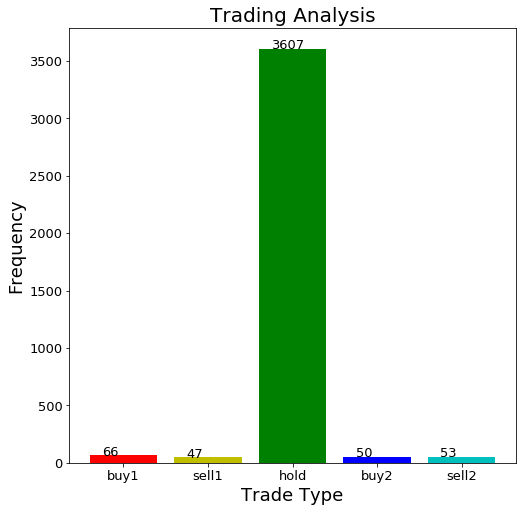

In [87]:
slices = [act_arr.count(0),act_arr.count(1),act_arr.count(2),act_arr.count(3),act_arr.count(4)]
activities = ['buy1', 'sell1', 'hold','buy2', 'sell2']
colors = ['r', 'y', 'g','b','c'] 
# plt.pie(slices, labels = activities, colors=colors,  
#         startangle=90, shadow = True, explode = (0.1, 0.1, 0.1,0.1,0.1), 
#         radius = 1.2, autopct = '%1.1f%%') 
# plt.legend()
# plt.show()
# plt.figure(figsize=(25,25))
fig, ax = plt.subplots(figsize=(8,8))
plt.bar(activities, slices, tick_label = activities, 
            width = 0.8, color = colors) 
for i,v in enumerate(slices):
    ax.text(i-.25, 
              v, 
              slices[i], 
              fontsize=13, 
              color='black')
plt.title('Trading Analysis',fontsize=20)

plt.xlabel('Trade Type', fontsize=18)
plt.ylabel('Frequency', fontsize = 18)
plt.xticks(fontsize = 13)    
plt.yticks(fontsize = 13)    

plt.show()

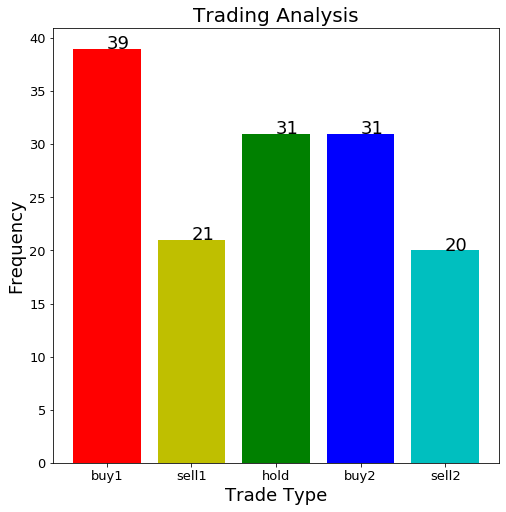

In [88]:
slices = [act_arr1.count(0),act_arr1.count(1),act_arr1.count(2),act_arr1.count(3),act_arr1.count(4)]
activities = ['buy1', 'sell1', 'hold','buy2', 'sell2']
colors = ['r', 'y', 'g','b','c'] 
# plt.pie(slices, labels = activities, colors=colors,  
#         startangle=90, shadow = True, explode = (0.1, 0.1, 0.1,0.1,0.1), 
#         radius = 1.2, autopct = '%1.1f%%') 
# plt.legend()

# plt.show()


fig, ax = plt.subplots(figsize=(8,8))
plt.bar(activities, slices, tick_label = activities, 
            width = 0.8, color = colors) 
for i,v in enumerate(slices):
    ax.text(i, 
              v, 
              slices[i], 
              fontsize=18, 
              color='black')

plt.title('Trading Analysis',fontsize=20)

plt.xlabel('Trade Type', fontsize=18)
plt.ylabel('Frequency', fontsize = 18)
plt.xticks(fontsize = 13)    
plt.yticks(fontsize = 13)   
plt.show()


In [58]:
set(act_arr1)

{0, 1, 2, 3, 4}

In [90]:
# # Test Stock Prices and actions taken by agent Stock Plot
# import matplotlib.pyplot as plt
# import datetime
# import numpy as np

# %matplotlib inline

# pd_bm=pd.DataFrame.from_records(Benchmark_Port_Value)
# pd_bm[0]=pd.to_datetime(pd_bm[0], format='%Y/%m/%d')

# x1 = np.array(pd_data1_test['Date'])
# y1 = portfolio_value

# x2=pd_bm[0]
# y2=pd_bm[1]

# print(x1.shape)
# # print(x2.shape)
# # print(y1.shape)
# print(y2.shape)


# plt.title("Portfolio Value vs Benchmark Over Test Data")
# plt.xlabel("Days")
# plt.ylabel("Portfolio Value in $")

# plt.plot(x1,y1)
# plt.plot_date(x2, y2, c = 'red', marker='v', linestyle='-')


# #plt.plot(x1, z, '-', color='black');
# plt.plot(x1, y1, '-', color='blue');



# #plt.scatter(x1,Benchmark_Port_Value,marker='o')

# plt.legend(('Trading Model', 'Benchmark'))

# plt.show()